In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
def train_model(X, y):
    model = SVR().fit(X, y)
    return model

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

           1
0           
2015-32    4
2015-33  392
2015-34  136
2015-35    1
2015-36   58
2015-37   94
2015-38   68
2015-39   93
2015-40  130
2015-41  220


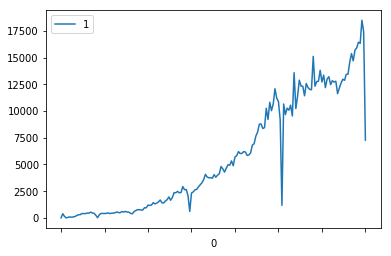

In [4]:
series = pd.read_csv("deliveries.csv", header=None, index_col=0, sep=";")
# series = pd.read_csv("annual-sunspot-relative-number-1.csv", header=0, index_col='Year', sep=";", squeeze=True)
serie = series.astype('float64')
print(series.head(10))

series.plot()
plt.show()

In [5]:
scaler = preprocessing.MinMaxScaler()
normalized_data = scaler.fit_transform(series)
data = series_to_supervised(normalized_data, 3, 12)
print(data.shape)
data.head(5)

(162, 15)


,var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),var1(t+10),var1(t+11)
3,0.000162,0.021153,0.007304,0.000000,0.003084,0.005031,0.003625,0.004977,0.006979,0.011848,0.016014,0.016393,0.022019,0.021640,0.021749
4,0.021153,0.007304,0.000000,0.003084,0.005031,0.003625,0.004977,0.006979,0.011848,0.016014,0.016393,0.022019,0.021640,0.021749,0.024670
5,0.007304,0.000000,0.003084,0.005031,0.003625,0.004977,0.006979,0.011848,0.016014,0.016393,0.022019,0.021640,0.021749,0.024670,0.023967
6,0.000000,0.003084,0.005031,0.003625,0.004977,0.006979,0.011848,0.016014,0.016393,0.022019,0.021640,0.021749,0.024670,0.023967,0.029269
7,0.003084,0.005031,0.003625,0.004977,0.006979,0.011848,0.016014,0.016393,0.022019,0.021640,0.021749,0.024670,0.023967,0.029269,0.025049


In [6]:
# split data to the desired percent
# shall pass the data array and the desired percent
# of data to be used on train
def split_data_x(data_array, percent):
    limit = int(len(data_array) * percent / 100)
    train = data_array[['var1(t-3)', 'var1(t-2)', 'var1(t-1)']].iloc[0:limit]
    test = data_array[['var1(t-3)', 'var1(t-2)', 'var1(t-1)']].iloc[limit:]
    return train, test

def split_data_y(data_array, percent, prediction_type='interactive'):
    limit = int(len(data_array) * percent / 100)
    data = []
    
    if prediction_type == 'interactive':
        column = 'var1(t)'
    elif prediction_type == 'direct':
        column = 'var1(t+11)'

    return data_array[column].iloc[0:limit], data_array['var1(t+11)'].iloc[limit:]
    
def direct_prediction(data):
    X_train, X_test = split_data_x(data, 67)
    y_train, y_test = split_data_y(data, 67, 'direct')
    
    model = train_model(X_train, y_train)
    preds = []

    for row in X_test.iterrows():
        preds.append(
            model.predict(
                [
                    [
                        row[1]['var1(t-3)'],
                        row[1]['var1(t-2)'],
                        row[1]['var1(t-1)']
                    ]
                ]
            )[0]
        )
    
    values = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

    mae = mean_absolute_error(values, preds)
    return mae

def iteractive_prediction(data):
    X_train, X_test = split_data_x(data, 67)
    y_train, y_test = split_data_y(data, 67)
    
    model = train_model(X_train, y_train)
    preds = []
    
    for row in X_test.iterrows():
        pred1 = model.predict([[row[1]['var1(t-3)'], row[1]['var1(t-2)'], row[1]['var1(t-1)']]])[0]
        pred2 = model.predict([[row[1]['var1(t-2)'], row[1]['var1(t-1)'], pred1]])[0]
        pred3 = model.predict([[row[1]['var1(t-1)'], pred1, pred2]])[0]
        pred4 = model.predict([[pred1, pred2, pred3]])[0]
        pred5 = model.predict([[pred2, pred3, pred4]])[0]
        pred6 = model.predict([[pred3, pred4, pred5]])[0]
        pred7 = model.predict([[pred4, pred5, pred6]])[0]
        pred8 = model.predict([[pred5, pred6, pred7]])[0]
        pred9 = model.predict([[pred6, pred7, pred8]])[0]
        pred10 = model.predict([[pred7, pred8, pred9]])[0]
        pred11 = model.predict([[pred8, pred9, pred10]])[0]
        pred12 = model.predict([[pred9, pred10, pred11]])[0]
        preds.append(pred12)
    
    values = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

    mae = mean_absolute_error(values, preds)
    return mae

In [7]:
print("MAE Direct Predictions: ", direct_prediction(data))
print("MAE Iteractive Predictions: ", iteractive_prediction(data))

MAE Direct Predictions:  1597.9247098594108
MAE Iteractive Predictions:  9205.773257757426


The best approach for the predictions was the Direct Predictions, with a MAE of =~ 1597.9